In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame = False)
print(type(mnist))
X = mnist["data"]
y = mnist["target"]

<class 'sklearn.utils._bunch.Bunch'>


In [13]:
def graph_img(img):
    img = img.reshape(28, 28)
    plt.imshow(img, cmap = "binary") # display as grayscale
    plt.axis("off")

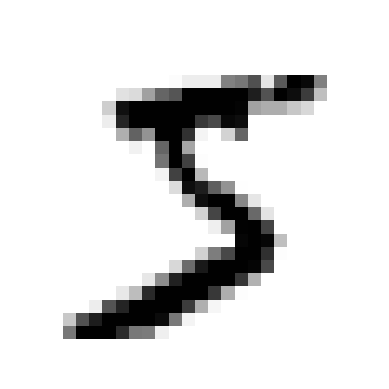

In [17]:
graph_img(X[0])

In [21]:
# split the data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Part 1: Train a Binary Classifier

In [24]:
y_train_5 = (y_train == "5")
y_test_5 = (y_test == "5")

**Train SGD Classifier**

In [26]:
from sklearn.linear_model import SGDClassifier
sgd_class = SGDClassifier(random_state = 42)
sgd_class.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

**Evaluate Performance**

In [31]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_class, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

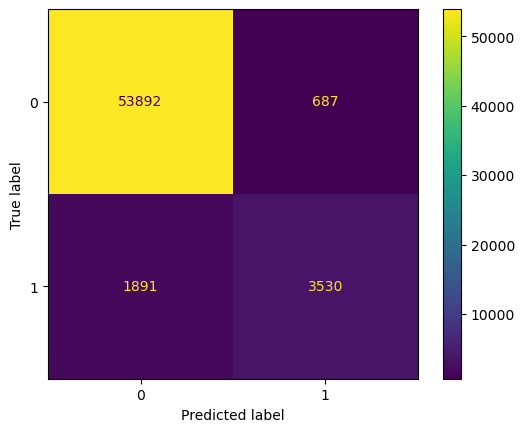

In [35]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_class, X_train, y_train_5, cv = 3)
cm = confusion_matrix(y_train_5, y_train_pred)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

In [37]:
from sklearn.metrics import precision_score, recall_score
print(f"Precision: {precision_score(y_train_5, y_train_pred)}")
print(f"Sensitivity (recall): {recall_score(y_train_5, y_train_pred)}")

Precision: 0.8370879772350012
Sensitivity (recall): 0.6511713705958311


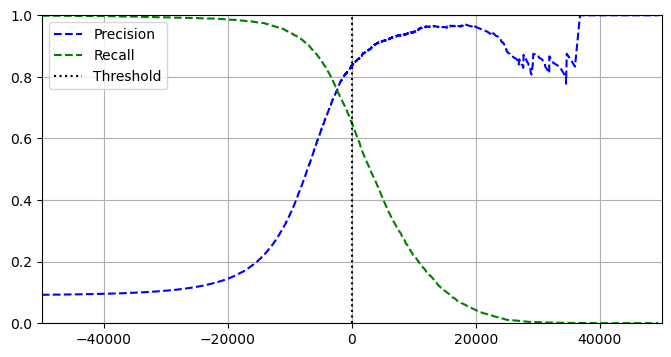

In [94]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_class, X_train, y_train_5, cv = 3, method = "decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
# plot the curve
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
plt.plot(thresholds, recalls[:-1], "g--", label = "Recall")
threshold = 0
plt.vlines(threshold, ymin = 0, ymax = 1, colors = "k", linestyles = "dotted", label = "Threshold")
plt.axis([-50000, 50000, 0, 1])
plt.legend()
plt.grid()
plt.show()

In [55]:
# select threshold, predict and evaluate
threshold_90_prec = thresholds[(precisions >= 0.90).argmax()]
y_train_pred_90 = (y_scores >= threshold_90_prec)
print(f"Precision: {precision_score(y_train_5, y_train_pred_90)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred_90)}")

Precision: 0.9000345901072293
Recall: 0.4799852425751706


ROC AUC: 0.9604938554008616


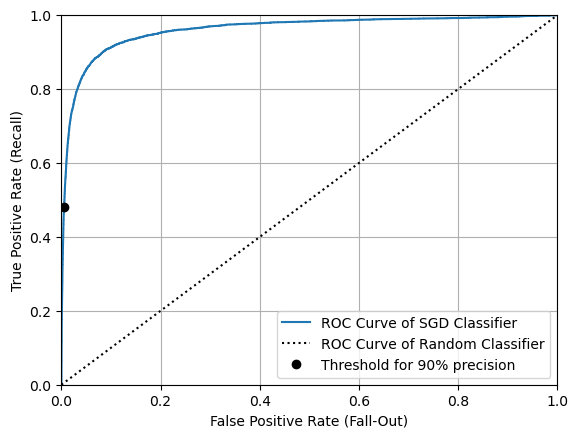

In [96]:
# graph roc curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
# find fpr and tpr for minimum threshold where precision > 90%
index = (thresholds <= threshold_90_prec).argmax()
fpr_90_prec = fpr[index]
tpr_90_prec = tpr[index]
print(f"ROC AUC: {roc_auc_score(y_train_5, y_scores)}")
# plot
plt.plot(fpr, tpr, label = "ROC Curve of SGD Classifier")
plt.plot(fpr, fpr, "k:", label = "ROC Curve of Random Classifier")
plt.plot(fpr_90_prec, tpr_90_prec, "ko", label = "Threshold for 90% precision")
plt.grid()
plt.legend()
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

**Train RandomForestClassifier**

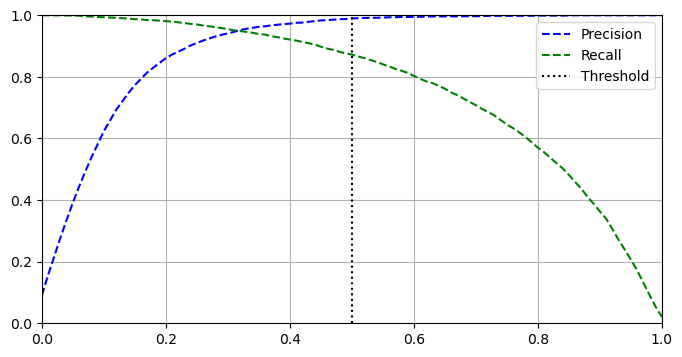

In [104]:
from sklearn.ensemble import RandomForestClassifier
forest_class = RandomForestClassifier(random_state = 42)
y_scores_forest = cross_val_predict(forest_class, X_train, y_train_5,
                                   cv = 3, method = "predict_proba")[:,1] # just probability for positive class
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)
plt.figure(figsize=(8, 4))
plt.plot(thresholds_forest, precisions_forest[:-1], "b--", label = "Precision")
plt.plot(thresholds_forest, recalls_forest[:-1], "g--", label = "Recall")
threshold = 0.5
plt.vlines(threshold, ymin = 0, ymax = 1, colors = "k", linestyles = "dotted", label = "Threshold")
plt.legend(loc = "upper right")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.show()

SGD Classifier: 0.9604938554008616
RandomForest Classifier: 0.9983436731328145


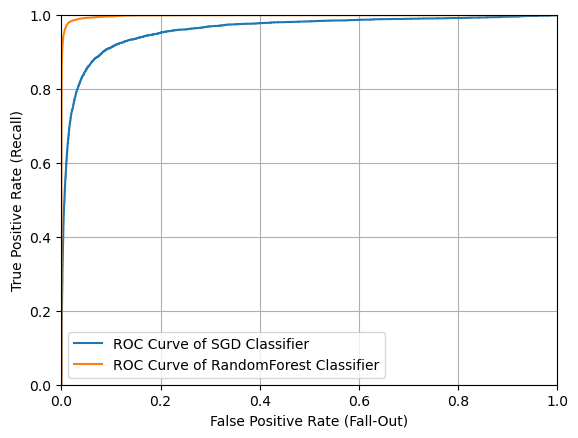

In [110]:
# compare sgd and random forest roc curves
print(f"SGD Classifier: {roc_auc_score(y_train_5, y_scores)}")
print(f"RandomForest Classifier: {roc_auc_score(y_train_5, y_scores_forest)}")
plt.plot(fpr, tpr, label = "ROC Curve of SGD Classifier")
fpr_for, tpr_for, thresholds_for = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr_for, tpr_for, label = "ROC Curve of RandomForest Classifier")
plt.grid()
plt.legend()
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

### Part 2: Multiclass Classification